<a href="https://colab.research.google.com/github/Shonn-Li/CS484-final-project/blob/main/CS484.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# libraries
import random
import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt
from typing import OrderedDict
from torch.utils.data import DataLoader, random_split
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Step 1: Prepare data
We will use CIFAR10 dataset.

In [ ]:
# define transform
cropSize = 224
norms = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

trainTrans = transforms.Compose(
    [
        transforms.Resize(cropSize),
        transforms.ToTensor(),
        transforms.Normalize(*norms)
    ]
)


caltech256 = datasets.Caltech256(root="./data", download=False, transform=trainTrans)

image label: 0


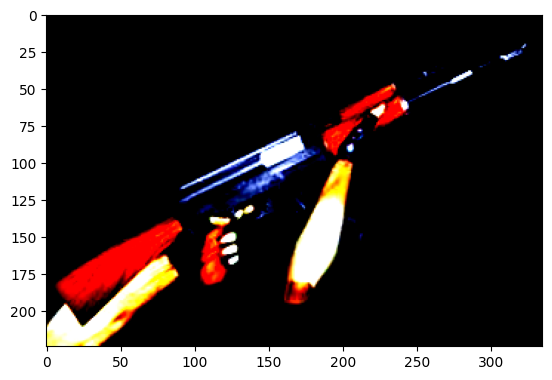

In [ ]:
img, label = caltech256[50]
print(f"image label: {label}")
plt.figure()
plt.imshow(torch.permute(img, (1, 2, 0)))

### Step 2: Define Network

In [ ]:
class MyModel(nn.Module):
    def __init__(self, num_classes):
        super(MyModel, self).__init__()

        # extract vgg19 feature layer
        vgg19 = models.vgg19(weights='DEFAULT')
        self.vgg19Feat = vgg19.features[:28] # result in 512x14x14
        for param in self.vgg19Feat.parameters():
            param.requires_grad = False

        # additional conv layer & average pooling
        self.process = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
            ('pool', nn.AdaptiveAvgPool2d((1, 1))),
            ('flatten', nn.Flatten()),
            ('linear', nn.Linear(1024, num_classes))
        ]))


    def forward(self, x):
        x = self.vgg19Feat(x)
        x = self.process(x)

        return x

### Step 3: Training

In [ ]:
# training function
def trainLoop(model, criterion, optimizer, dataloader, max_epoch):
    losses = []
    accuracies = []
    model.train()
    for epoch in range(max_epoch):
        epoch_loss = 0
        epoch_correct = 0
        dataCount = 0
        for batch in dataloader:
            optimizer.zero_grad()
            images, labels = batch[0].to(device), batch[1].to(device)

            outputs = model(images)
            _, preds = outputs.max(dim=1)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            dataCount += images.size(0)

            epoch_correct += torch.eq(preds, labels).sum().item()

            loss.backward()
            optimizer.step()

        # gather loss
        epoch_avg_loss = epoch_loss / dataCount
        epoch_acc = epoch_correct / dataCount
        losses.append(epoch_avg_loss)
        accuracies.append(epoch_acc)
        print(f"Epoch {epoch + 1}， loss is {epoch_avg_loss:.3f}, accuracy is {epoch_acc:.3f}")

    return losses, accuracies

In [ ]:
# split data into test and training sets
train_size = int(0.8 * len(caltech256))
test_size = len(caltech256) - train_size
train_dataset, test_dataset = random_split(caltech256, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
# perform training
model = MyModel().to(device)
criterion = nn.CrossEntropyLoss()
parameters = [{'params': model.process.parameters()}]
optimizer = optim.Adam(parameters, lr=0.001)
train_loss, train_acc = trainLoop(model, criterion)